Importamos dependencias

In [160]:
##!pip install descartes

In [101]:
# Librerias para el tratamiento de los datos
import pandas as pd
import numpy as np
import math

# Librerias para la graficación de los datost
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()
import plotly.express as px
import plotly.graph_objects as go

# Permite que las graficas se generen a mayor resolucion
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Permite ignorar los warnings de la libreta al generar algunos modelos
import warnings
warnings.simplefilter('ignore')

# Establece un ancho de libreta mayor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Importamos la libreria de fechas
from datetime import datetime

# Para embed HTML, JS objects
from IPython.display import Javascript
from IPython.core.display import display, HTML

# Trabajar con geo data
import geopandas as gpd
from geopandas.tools import geocode


Cargamos los datos del mapa mundi

In [102]:
world_map = gpd.read_file('./data/countries.geojson')
world_map.rename(columns={"ADMIN": "country", "ISO_A3": "country_code"}, inplace=True)
# Delete Antarctica
world_map = world_map[world_map['country']!='Antarctica']
# Correct names
world_map['country'] = world_map['country'].apply(lambda c: c.replace(" ", "_"))

Cargamos los datos referidos al covid

In [122]:
df = pd.read_csv('./data/covid19-cases-worldwide.csv')
df['dateRep'] = df['dateRep'].apply(lambda d: datetime.strptime(d, "%d/%m/%Y").date())

Eliminamos valores perdidos

In [123]:
df.dropna(axis=0, inplace=True)

Renombramos algunas de las variables y nos cargamos otras

In [124]:
df.rename(columns={"dateRep": "date", "countriesAndTerritories": "countries", "popData2018": "population", "continentExp": "continent"}, inplace=True)

In [125]:
df.head()

date  day  month  year  cases  deaths    countries geoId  \
0  2020-05-30   30      5  2020    623      11  Afghanistan    AF   
1  2020-05-29   29      5  2020    580       8  Afghanistan    AF   
2  2020-05-28   28      5  2020    625       7  Afghanistan    AF   
3  2020-05-27   27      5  2020    658       1  Afghanistan    AF   
4  2020-05-26   26      5  2020    591       1  Afghanistan    AF   

  countryterritoryCode  population continent  
0                  AFG  37172386.0      Asia  
1                  AFG  37172386.0      Asia  
2                  AFG  37172386.0      Asia  
3                  AFG  37172386.0      Asia  
4                  AFG  37172386.0      Asia

In [126]:
df.describe()

day         month          year         cases        deaths  \
count  19866.000000  19866.000000  19866.000000  19866.000000  19866.000000   
mean      16.415685      3.639787   2019.996678    296.942616     18.367210   
std        8.743235      1.375458      0.057545   1771.117081    125.668596   
min        1.000000      1.000000   2019.000000  -2461.000000  -1918.000000   
25%        9.000000      3.000000   2020.000000      0.000000      0.000000   
50%       17.000000      4.000000   2020.000000      3.000000      0.000000   
75%       24.000000      5.000000   2020.000000     50.000000      1.000000   
max       31.000000     12.000000   2020.000000  48529.000000   4928.000000   

         population  
count  1.986600e+04  
mean   5.018976e+07  
std    1.727964e+08  
min    1.000000e+03  
25%    2.119275e+06  
50%    9.630959e+06  
75%    3.369995e+07  
max    1.392730e+09

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19866 entries, 0 to 20292
Data columns (total 11 columns):
date                    19866 non-null object
day                     19866 non-null int64
month                   19866 non-null int64
year                    19866 non-null int64
cases                   19866 non-null int64
deaths                  19866 non-null int64
countries               19866 non-null object
geoId                   19866 non-null object
countryterritoryCode    19866 non-null object
population              19866 non-null float64
continent               19866 non-null object
dtypes: float64(1), int64(5), object(5)
memory usage: 1.8+ MB


In [128]:
df_spain = df[df['countries']=='Spain']
df_spain.head()

date  day  month  year  cases  deaths countries geoId  \
17348  2020-05-29   29      5  2020    658       2     Spain    ES   
17349  2020-05-28   28      5  2020   1137       1     Spain    ES   
17350  2020-05-27   27      5  2020    510       1     Spain    ES   
17351  2020-05-26   26      5  2020    859     283     Spain    ES   
17352  2020-05-25   25      5  2020   -372   -1918     Spain    ES   

      countryterritoryCode  population continent  
17348                  ESP  46723749.0    Europe  
17349                  ESP  46723749.0    Europe  
17350                  ESP  46723749.0    Europe  
17351                  ESP  46723749.0    Europe  
17352                  ESP  46723749.0    Europe

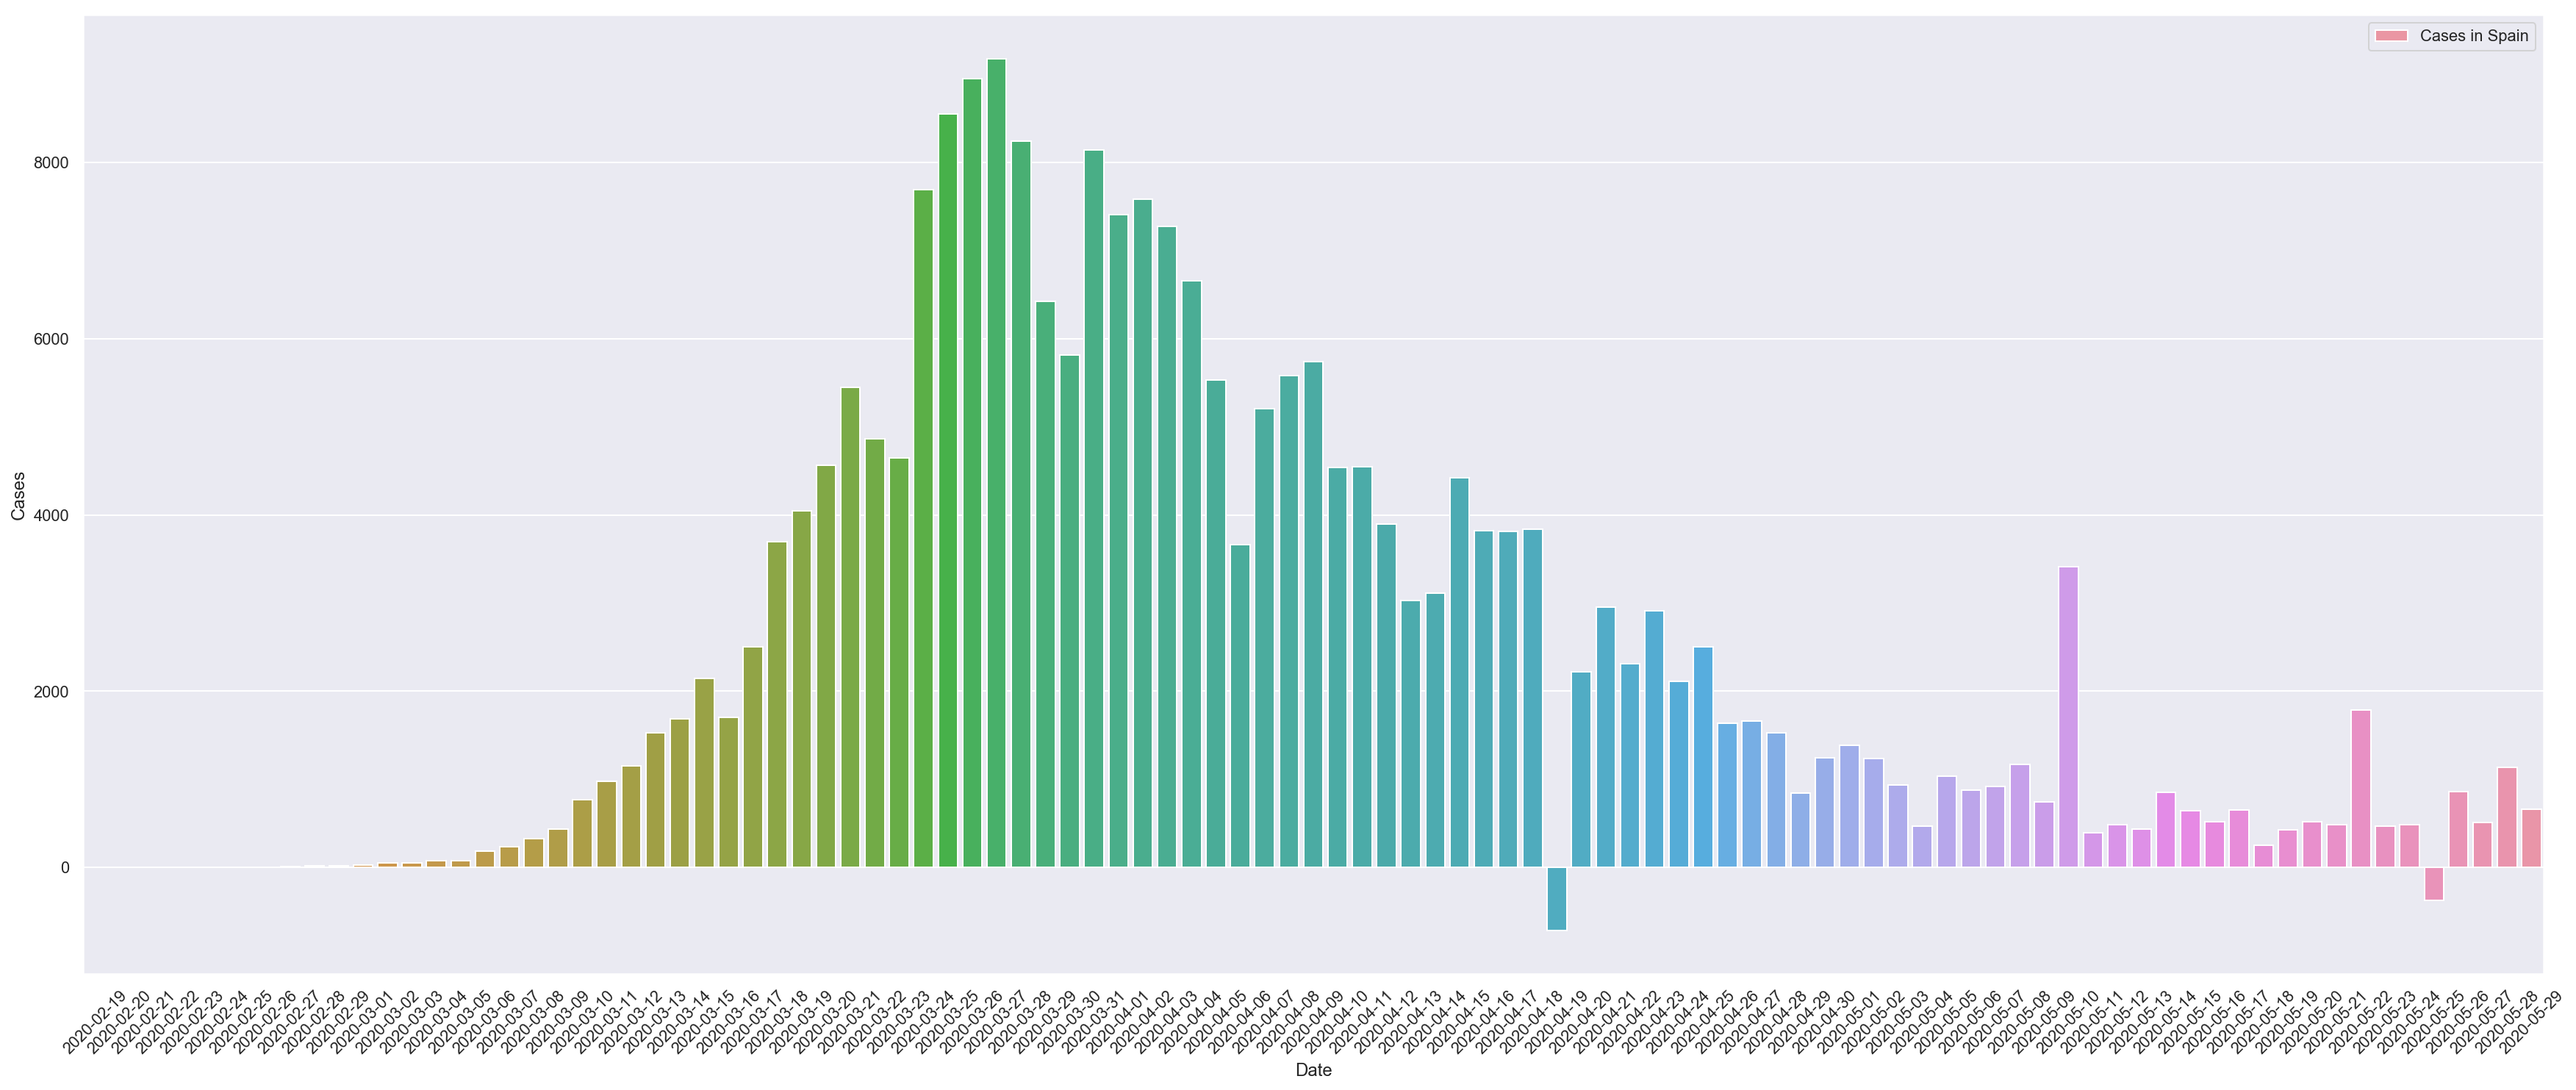

In [129]:
plt.figure(figsize=(30,12))
sns.barplot(x='date', y='cases', data=df_spain.sort_values(by=['date'])[50:], label='Cases in Spain')
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

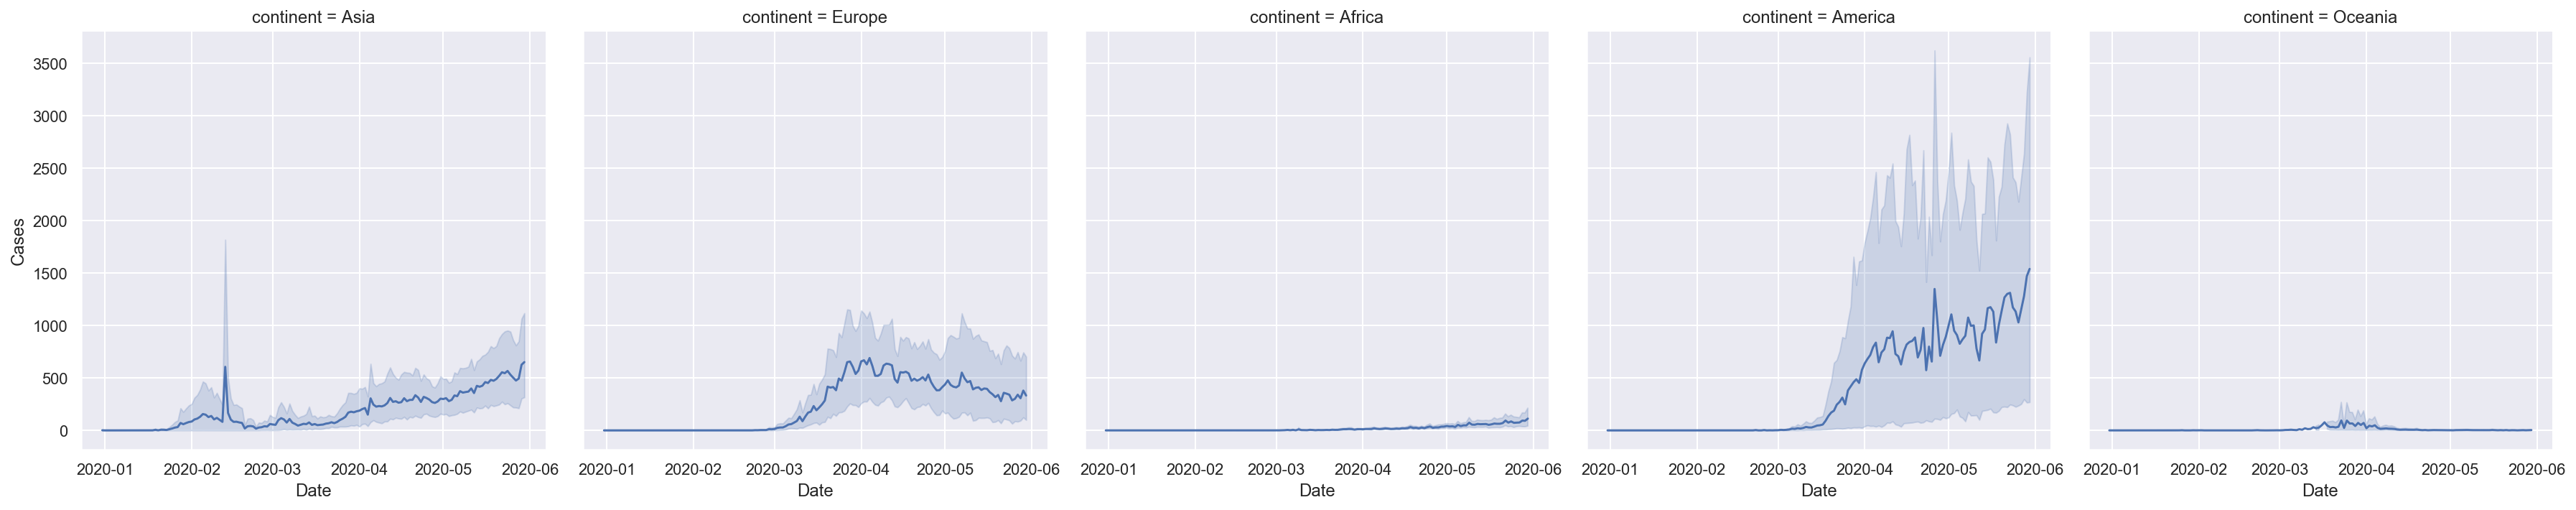

In [253]:
ax = sns.relplot(x="date", y="cases", col="continent", col_wrap=5, kind="line", data=df)
ax.set(xlabel='Date', ylabel='Cases');

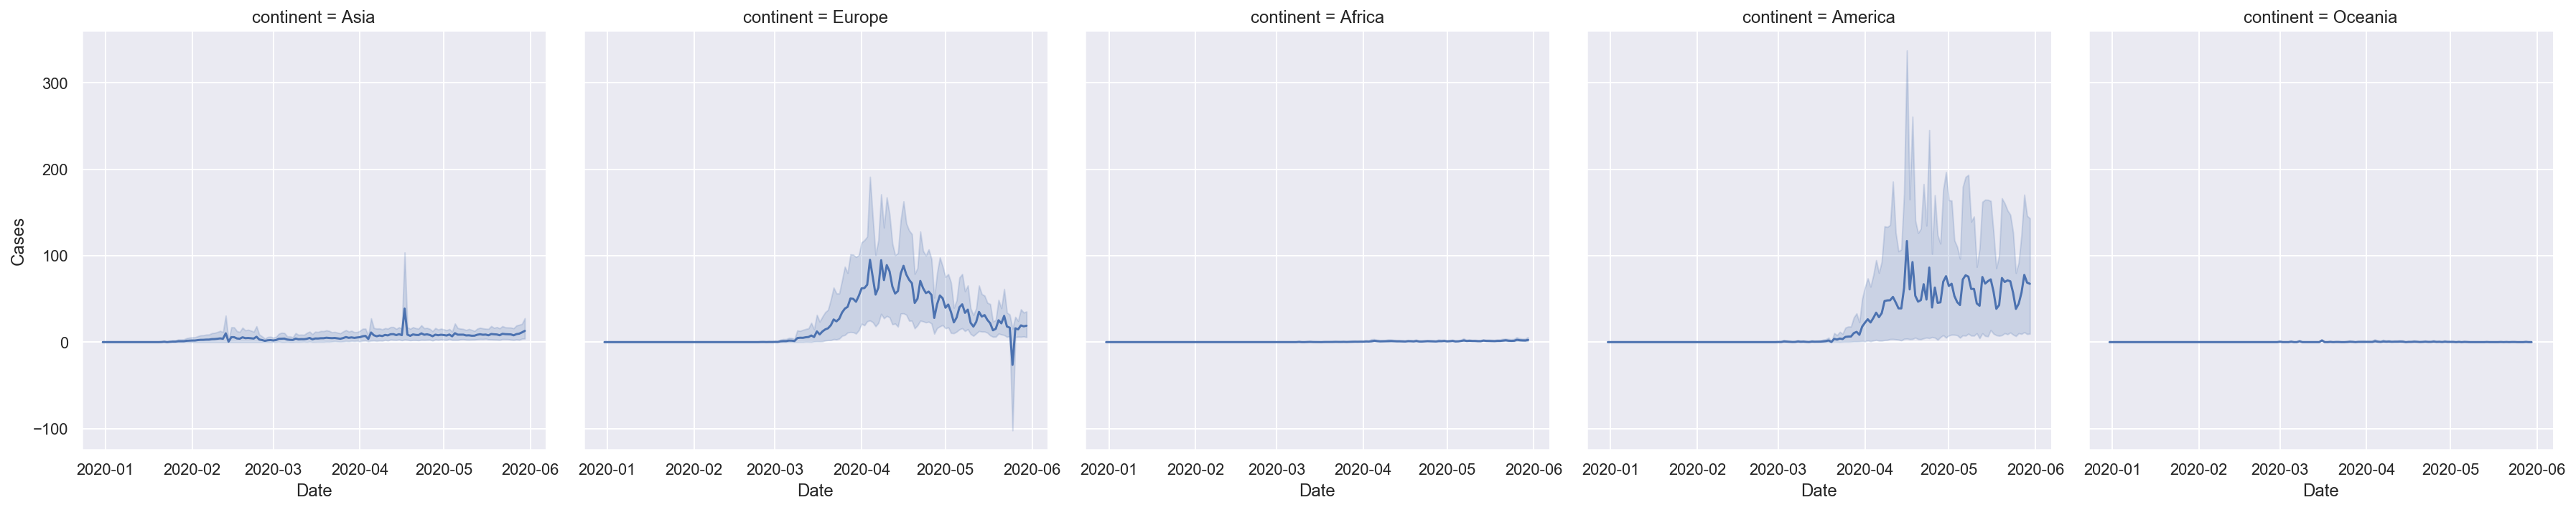

In [254]:
ax = sns.relplot(x="date", y="deaths", col="continent", col_wrap=5, kind="line", data=df)
ax.set(xlabel='Date', ylabel='Deaths');

## Analizar población por continente para ver si hay correlación entre densidad de población y contagios

In [213]:
dic_pop = {}
dic_cases = {}
dic_deaths = {}

for c in df.continent.unique():
    dic_pop[c] = (df[df.continent == c].groupby('countries')['population'].max().sum())
    dic_cases[c] = (df[df.continent == c].groupby('countries')['cases'].sum().sum())
    dic_deaths[c] = (df[df.continent == c].groupby('countries')['deaths'].sum().sum())
    
df_population = pd.DataFrame.from_dict(dic_pop, orient='index', columns=['population']).reset_index()
df_population.rename(columns={"index": "Continent", "population": 'Population'}, inplace=True)

df_cases = pd.DataFrame.from_dict(dic_cases, orient='index', columns=['cases']).reset_index()
df_cases.rename(columns={"index": "Continent", "cases": 'Cases'}, inplace=True)

df_death = pd.DataFrame.from_dict(dic_deaths, orient='index', columns=['deaths']).reset_index()
df_death.rename(columns={"index": "Continent", "deaths": 'Deaths'}, inplace=True)

df_continent = df_population.merge(df_cases, on="Continent")
df_continent = df_continent.merge(df_death, on="Continent")

Obtenemos la correlación entre población, contagios y muertos

In [214]:
df_continent

Continent    Population    Cases  Deaths
0      Asia  4.468916e+09  1068544   29542
1    Europe  7.644023e+08  1917491  172421
2    Africa  1.268520e+09   135064    3922
3   America  1.005667e+09  2769337  158866
4   Oceania  4.015206e+07     8626     132

In [215]:
df_continent.corr()

Population     Cases    Deaths
Population    1.000000  0.036225 -0.208282
Cases         0.036225  1.000000  0.924371
Deaths       -0.208282  0.924371  1.000000

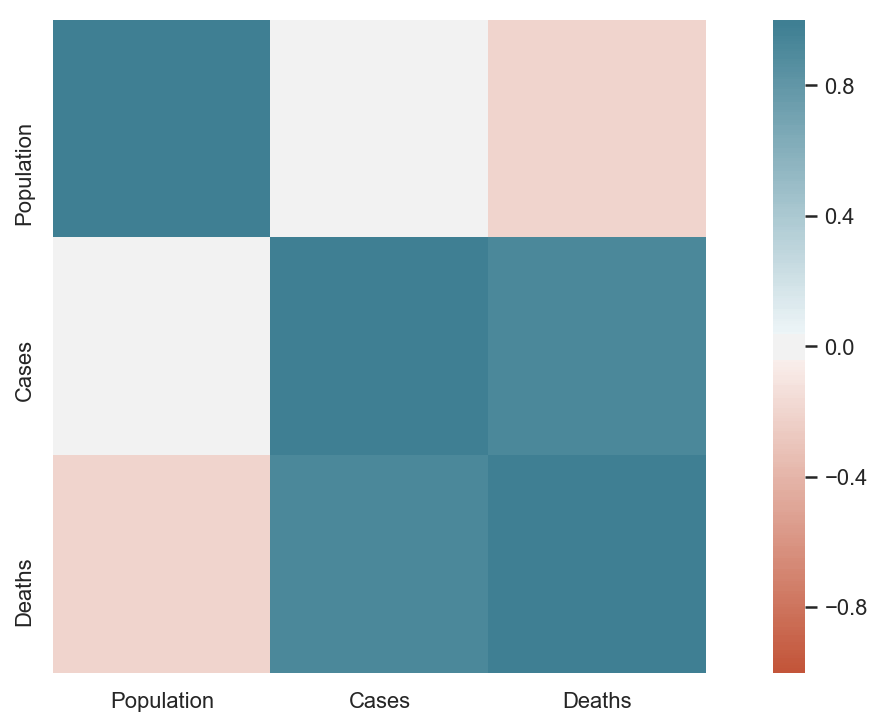

In [216]:
plt.figure(figsize=(12,6))
sns.heatmap(df_continent.corr(), 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True
           )

In [217]:
import plotly.express as px
fig = px.pie(df_continent, values='Population', names='Continent', title='Mundial population: '+ str(df_continent.Population.sum()))
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

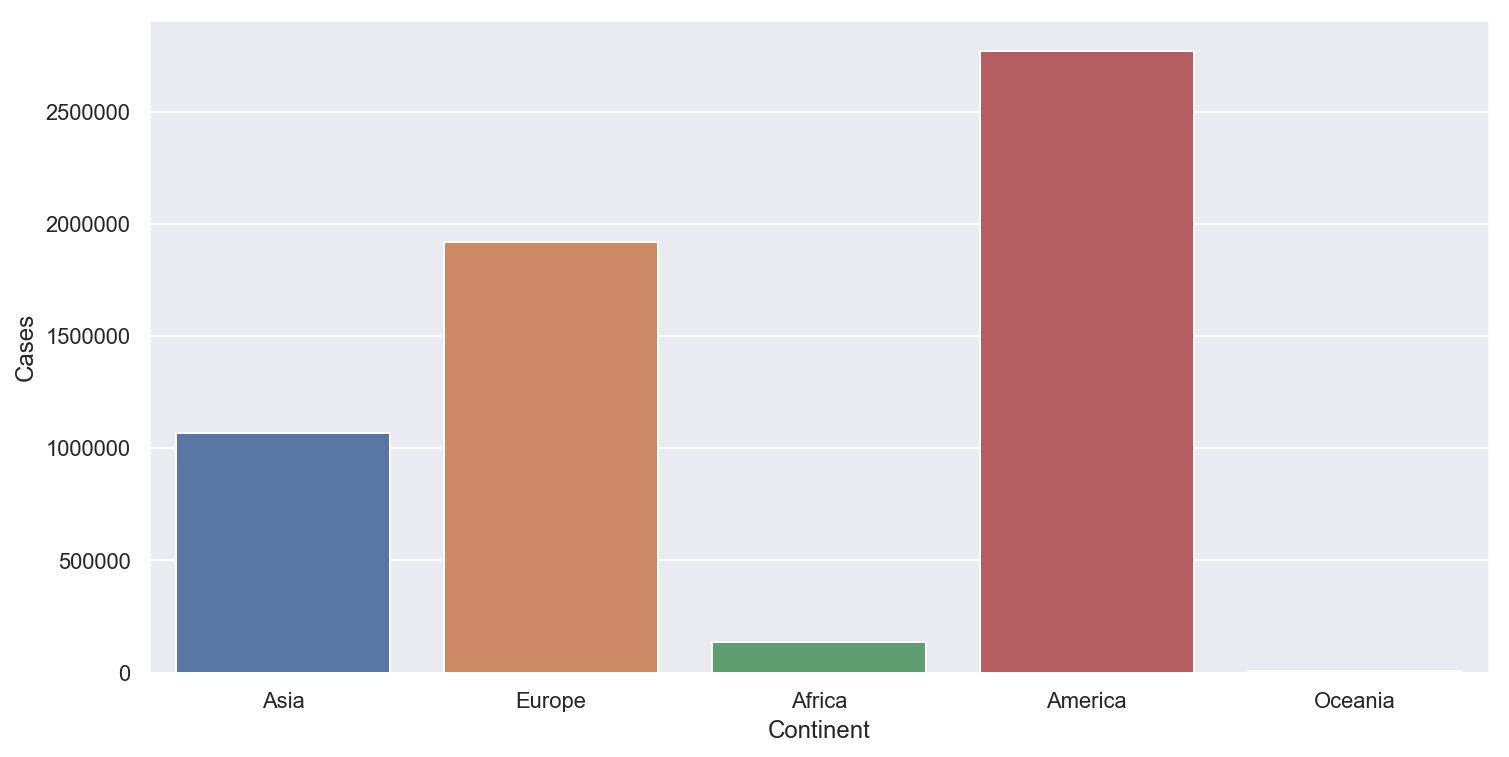

In [218]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Continent', y='Cases', data=df_continent)
plt.show()

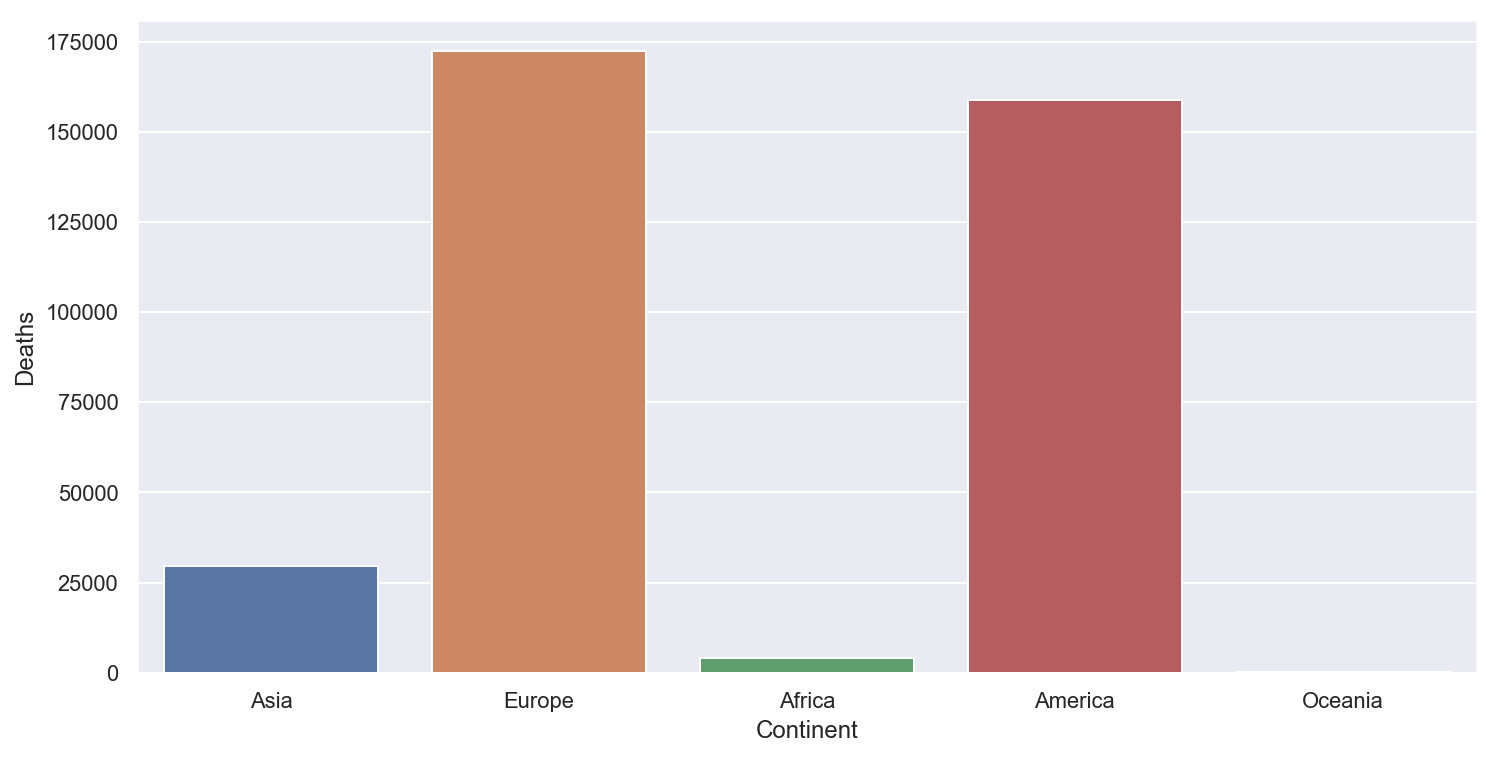

In [219]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Continent', y='Deaths', data=df_continent)
plt.show()

## Paises afectados por el covid-19

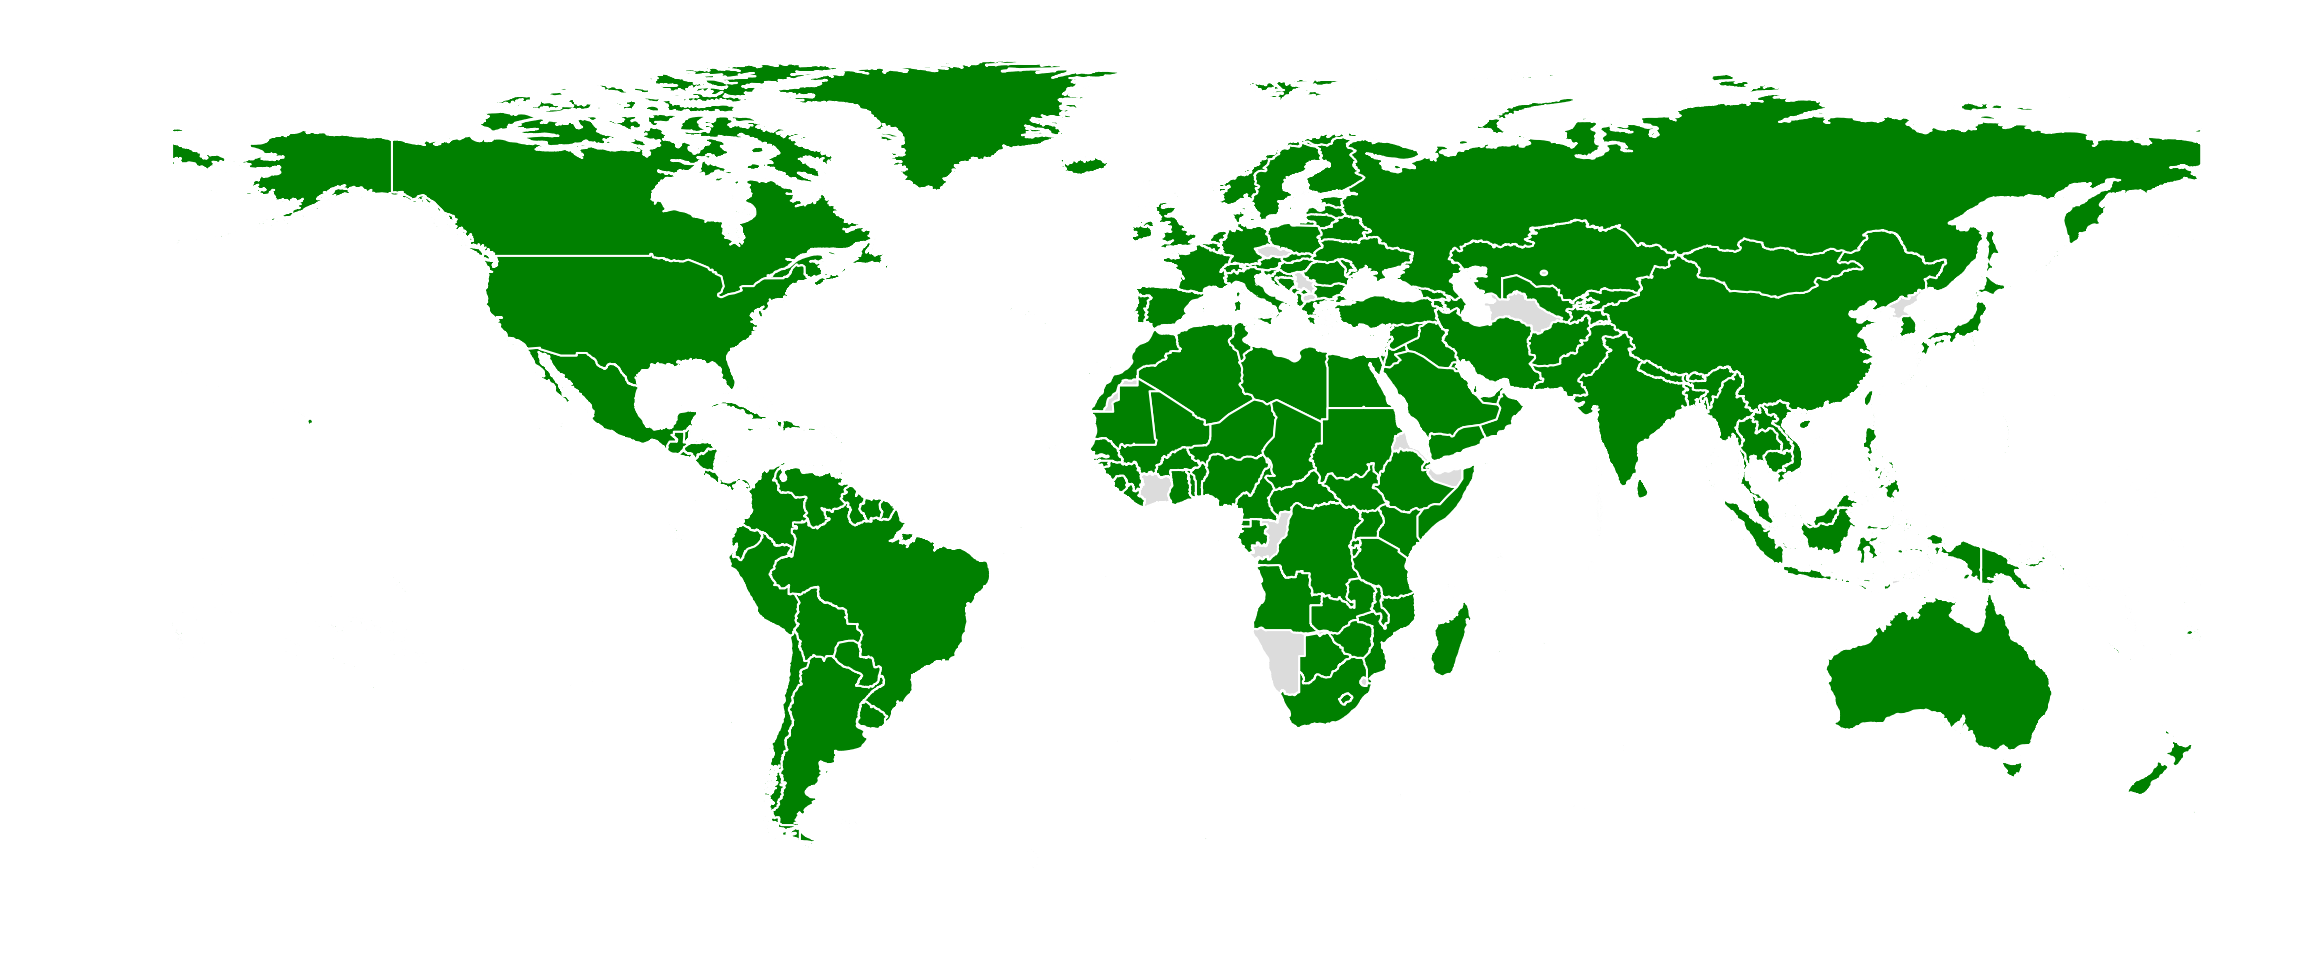

In [15]:
covid_countries = world_map[world_map['country'].isin(df['countries'].unique())]

fig, ax = plt.subplots(figsize=(20, 12))
world_map.plot(ax=ax, color='gainsboro')
covid_countries.plot(ax=ax, color='green', markersize=10)

ax.set_axis_off()

In [232]:
df_countries = df.groupby('countries')[['countryterritoryCode']].max()
df_countries['cases'] = df.groupby('countries')[['cases']].sum()
df_countries['deaths'] = df.groupby('countries')[['deaths']].sum()
df_countries['continent'] = df.groupby('countries')[['continent']].max()
df_countries = df_countries.reset_index()
df_countries.head()

countries countryterritoryCode  cases  deaths continent
0  Afghanistan                  AFG  13659     246      Asia
1      Albania                  ALB   1099      33    Europe
2      Algeria                  DZA   9134     638    Africa
3      Andorra                  AND    764      51    Europe
4       Angola                  AGO     77       4    Africa

In [236]:
fig = px.scatter_geo(
    df_countries, 
    locations='countryterritoryCode',
    color='continent',
    hover_name='countries',
    size='cases',
    projection="natural earth",
    title='World COVID-19 Total Cases'
)
fig.show()

fig = px.scatter_geo(
    df_countries, 
    locations='countryterritoryCode',
    color='continent',
    hover_name='countries',
    size='deaths',
    projection="natural earth",
    title='World COVID-19 Total Deaths'
)
fig.show()

---

# Mapas interactivos

In [250]:
df_map_global = df.copy()
# Sort the data frame on date
df_map_global = df_map_global.sort_values(by=['date'])
# Convert date to string type
df_map_global['date'] = df_map_global.date.apply(lambda d: datetime(d.year, d.month, d.day).strftime('%Y-%m-%d'))
# Correct the values negatives
df_map_global[df_map_global['cases']<0] = 0 
df_map_global[df_map_global['deaths']<0] = 0 

In [251]:
fig = px.scatter_geo(
    df_map_global, 
    locations='countryterritoryCode',
    color='continent',
    hover_name='countries',
    size='cases',
    projection="natural earth",
    title='World COVID-19 Cases Per Day',
    animation_frame="date"
)
fig.show()

fig = px.scatter_geo(
    df_map_global, 
    locations='countryterritoryCode',
    color='continent',
    hover_name='countries',
    size='deaths',
    projection="natural earth",
    title='World COVID-19 Deaths Per Day',
    animation_frame="date"
)
fig.show()

# Trafico aereo

In [73]:
df_trafico_aereo_temporal = pd.read_csv('./Datos de Trafico Aereo/COVID_7D_portal_Overview_Serie temporal.csv', parse_dates=['Date'])
df_trafico_aereo_temporal.rename(columns={'Daily new COVID-19 cases (7 day moving avg.)': "Cases"}, inplace=True)

In [80]:
df_trafico_comercial = pd.read_csv('./Datos de Trafico Aereo/number-of-commercial-fli.csv', sep=';', parse_dates=['DateTime'])
df_trafico_comercial.rename(columns={'7-day moving average': "Cases", "DateTime": "Date", "Number of flights": "Flights"}, inplace=True)

In [95]:
df_trafico_total = pd.read_csv('./Datos de Trafico Aereo/total-number-of-flights.csv', sep=';', parse_dates=['DateTime'])
df_trafico_total.rename(columns={'7-day moving average': "Cases", "DateTime": "Date", "Number of flights": "Flights"}, inplace=True)

In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_trafico_aereo_temporal['Date'], y=df_trafico_aereo_temporal['2010'],
                    mode='lines',
                    name='2010'))
fig.add_trace(go.Scatter(x=df_trafico_aereo_temporal['Date'], y=df_trafico_aereo_temporal['2019'],
                    mode='lines',
                    name='2019'))
fig.add_trace(go.Scatter(x=df_trafico_aereo_temporal['Date'], y=df_trafico_aereo_temporal['2020'],
                    mode='lines',
                    name='2020'))
fig.add_trace(go.Scatter(x=df_trafico_aereo_temporal['Date'], y=df_trafico_aereo_temporal['Cases'],
                    mode='lines',
                    name='Daily COVID-19 Cases (7 day moving avg.)'))

fig.update_layout(title='Evolution of daily flights (7 day moving average)',yaxis_title='Flights')


fig.show()

En 2010 se observa un pico, y esto es debido a la crisis volcanica que ocurrio durante el mes de marzo y mayo.


In [98]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_trafico_comercial['Date'], y=df_trafico_comercial['Flights'],
                    mode='lines',
                    name='Number of commercial flights', fill='tozeroy'))

fig.add_trace(go.Scatter(x=df_trafico_comercial['Date'], y=df_trafico_comercial['Cases'],
                    mode='lines',
                    name='7 day moving average in commercial flights'))

fig.add_trace(go.Scatter(x=df_trafico_total['Date'], y=df_trafico_total['Flights'],
                    mode='lines',
                    name='Number of flights', fill='tozeroy'))

fig.add_trace(go.Scatter(x=df_trafico_total['Date'], y=df_trafico_total['Cases'],
                    mode='lines',
                    name='7 day moving average in total flights'))

fig.update_layout(title='Number of commercial and total flights tracked per day',yaxis_title='Number of flights')


fig.show()

Comentar grafica

---

# Union de datos del covid con los vuelos

In [205]:
df_dates = df.groupby('date')[['cases', 'deaths']].sum().reset_index()

In [206]:
df_dates_flights = pd.merge(df_dates, df_trafico_aereo_temporal['2020'], how='inner', left_index=True, right_index=True)
df_dates_flights.rename(columns={'2020': "flights"}, inplace=True)

In [207]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_dates_flights['date'], y=df_dates_flights['cases'],
                    mode='lines',
                    name='Cases'))
fig.add_trace(go.Scatter(x=df_dates_flights['date'], y=df_dates_flights['flights'],
                    mode='lines',
                    name='Flights'))

fig.update_layout(title='Evolution of daily flights and cases for COVID-19')

fig.show()

In [208]:
df_dates_flights.corr().style.background_gradient(cmap='coolwarm')

# Carbon dioxide

datos de https://climate.nasa.gov/vital-signs/carbon-dioxide/

In [314]:
df_co = pd.read_csv('./Gases/co2_mm_mlo.txt', sep='\s+', header=None)
df_co.columns = ['year', 'month', 'decimal_date', 'average', 'interpolated', 'trend', 'days']
df_co.head()

year  month  decimal_date  average  interpolated   trend  days
0  1958      3      1958.208   315.71        315.71  314.62    -1
1  1958      4      1958.292   317.45        317.45  315.29    -1
2  1958      5      1958.375   317.50        317.50  314.71    -1
3  1958      6      1958.458   -99.99        317.10  314.85    -1
4  1958      7      1958.542   315.86        315.86  314.98    -1

In [315]:
df_co['date'] = df_co.apply(lambda r: datetime(year=int(r['year']), month=int(r['month']), day=28), axis=1)

In [316]:
df_co.tail()

year  month  decimal_date  average  interpolated   trend  days       date
741  2019     12      2019.958   411.76        411.76  412.44    31 2019-12-28
742  2020      1      2020.042   413.39        413.39  413.07    29 2020-01-28
743  2020      2      2020.125   414.11        414.11  413.26    28 2020-02-28
744  2020      3      2020.208   414.51        414.51  413.02    26 2020-03-28
745  2020      4      2020.292   416.21        416.21  413.38    28 2020-04-28

In [323]:
df_co_copy = df_co[df_co['year']>=2004]

In [328]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_co_copy['date'], y=df_co_copy['trend'],
                    mode='lines+markers'))

fig.update_layout(title='DIRECT MEASUREMENTS CO2: 2005-PRESENT', xaxis_title="Year", yaxis_title="CO2 (parts per million)")

fig.show()